# Dump "Complementary filter"

Attitude estimation is determined from attitude propagation based on Gyro and measurements of tilt, roll and yaw
based on accelerometer and magnetometer, following [ahrs_python:doc](https://ahrs.readthedocs.io/en/latest/filters/complementary.html).

Basic idea is to combine attitude propagation (gyro, $\mathbf{q}_\mathrm{\omega}$) and attitude measurement
(magnetometer and accelormehter, $\mathbf{q}_\mathrm{am}$ with a complementary factor $\alpha$:

$
\mathbf{q} = (1 - \alpha) \mathbf{q}_\omega + \alpha\mathbf{q}_{am}, \quad \alpha \in (0, 1)
$

* yaw angle $\psi$: for North east down frame the angle between north and x axis in horizontal place
* pitch angle $\phi$: angle between horizontal plane and x axis
* roll angle $\theta$:

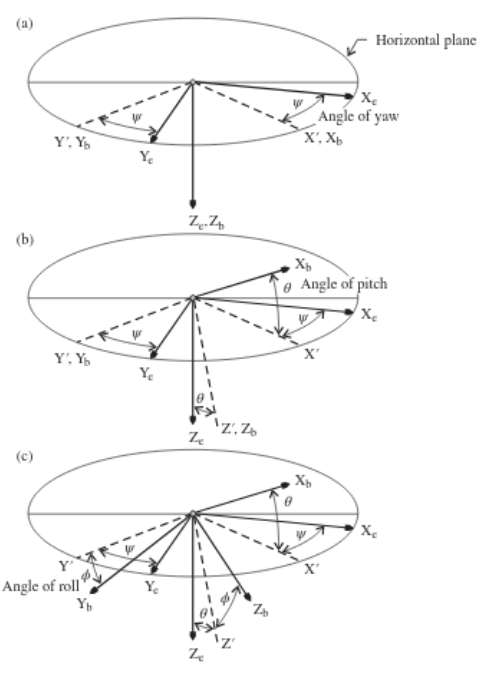

In [122]:
from matplotlib import pyplot as plt
import numpy as np
import sympy
import quaternionic as quat
from scipy.integrate import cumtrapz
from sympy import sin, cos, symbols
from sympy.matrices import rot_axis1, rot_axis2, rot_axis3
from sympy.algebras.quaternion import Quaternion

## Configuration parameters

In [209]:
# num of samples
T = 15 #s
n = 50000

# Gyro
gyro_noise = 0.003
gyro_bias = [0.002, 0.02, 0.01]

# Accelerometer
acc_noise = 0.02
acc_bias = [0.1, 0.07, 0.1]

# Magnetometer
mag_noise = 0.01
mag_bias = np.zeros(3) #[0.03, 0.02, 0.04]

In [180]:
# timesteps between samples
Δt = T / n

# rotation velocities in body frame
ωs = np.zeros((n, 3), dtype=float)
ωs[:,1] = np.sin(np.linspace(0, 2*np.pi, n))/25

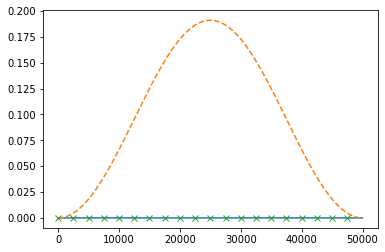

In [181]:
θs = cumtrapz(ωs, dx=Δt, axis=0, initial=0.0)

plt.plot(θs[:,0],'-')
plt.plot(θs[:,1],'--')
plt.plot(θs[:,2],'x', markevery=n//20)

In [182]:
_tmp = np.array([[0.0, 1.0, 0.0]] * n) * θs[:,1][:,np.newaxis]
qs = quat.array.from_axis_angle(_tmp)

## Simulated Measurements

### Gyro

In [189]:
ωs_ = ωs + np.random.normal(gyro_bias, scale=gyro_noise, size=(n,3))

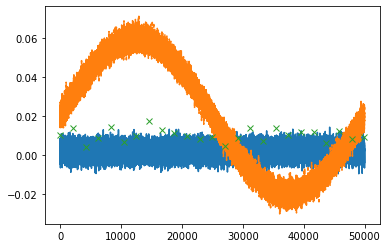

In [190]:
plt.plot(ωs_[:,0])
plt.plot(ωs_[:,1], '--')
plt.plot(ωs_[:,2], 'x', markevery=n//24)

### Accelerometer

In [210]:
g = np.array([0,0,-1])

a = (qs.to_rotation_matrix @ g) \
    + np.random.normal(acc_bias, scale=acc_noise, size=(n, 3))

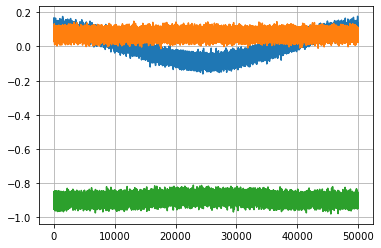

In [211]:
plt.plot(a[:,0])
plt.plot(a[:,1])
plt.plot(a[:,2])
plt.grid()

### Magnetometer

In [195]:
bs_0 = np.array([19355.97, 0, 4495.36]) # values from https://www.geomatrix.co.uk/tools/magnetic-field-calculator/
bs_0 = bs_0 / np.linalg.norm(bs_0)

ms = qs.to_rotation_matrix @ bs_0  \
    + np.random.normal(mag_bias, scale=mag_noise, size=(n,3))

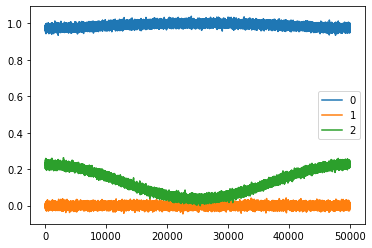

In [196]:
plt.plot(ms[:,0], label='0')
plt.plot(ms[:,1], label='1')
plt.plot(ms[:,2], label='2')

plt.legend();

## Attitude Propagation

In [197]:
def propagate_attitude(q, ω, Δt):
    q0 = q.to_scalar_part
    q1, q2, q3 = q.to_vector_part
    G = np.array([
        [-q1, q0, q3,-q2],
        [-q2,-q3, q0, q1],
        [-q3, q2,-q1, q0]
    ])
    
    return q + quat.array(0.5 * G.T @ (ω * Δt))

In [198]:
q_gyro = quat.array(np.zeros((n, 4)))
q_gyro[0, :] = (1.0, 0, 0, 0)

for i, ω in enumerate(ωs_[1:, :], start=1):
    q_gyro[i, :] = propagate_attitude(q_gyro[i-1,:], ω, Δt)

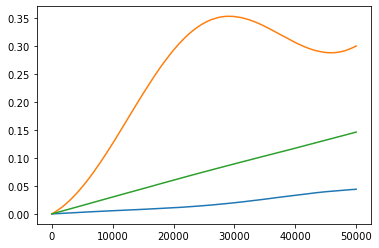

In [199]:
plt.plot(q_gyro.to_axis_angle)

## Attitude Measurement (Acc, Mag)

pitch $\phi$ and roll $\theta$ from accelerometer

$
\begin{array}{rcl}
\theta &=& \mathrm{arctan2}(a_y, a_z) \\
\phi &=& \mathrm{arctan2}\big(-a_x, \sqrt{a_y^2+a_z^2}\big)
\end{array}
$   

yaw $\psi$ from mag

$
\begin{array}{rcl}
\mathbf{b} &=&
\begin{bmatrix}
    \cos\theta & \sin\theta\sin\phi & \sin\theta\cos\phi \\
    0 & \cos\phi & -\sin\phi \\
    -\sin\theta & \cos\theta\sin\phi & \cos\theta\cos\phi
\end{bmatrix}
\begin{bmatrix}m_x \\ m_y \\ m_z\end{bmatrix} \\
\begin{bmatrix}b_x \\ b_y \\ b_z\end{bmatrix} &=&
\begin{bmatrix}
    m_x\cos\theta + m_y\sin\theta\sin\phi + m_z\sin\theta\cos\phi \\
    m_y\cos\phi - m_z\sin\phi \\
    -m_x\sin\theta + m_y\cos\theta\sin\phi + m_z\cos\theta\cos\phi
\end{bmatrix}
\end{array}
$

$
\begin{array}{rcl}
\psi &=& \mathrm{arctan2}(-b_y, b_x) \\
&=& \mathrm{arctan2}\big(m_z\sin\phi - m_y\cos\phi, \; m_x\cos\theta + \sin\theta(m_y\sin\phi + m_z\cos\phi)\big)
\end{array}
$

Combine into quaternion

$
\mathbf{q}_{am} =
\begin{pmatrix}q_w\\q_x\\q_y\\q_z\end{pmatrix} =
\begin{pmatrix}
    \cos\Big(\frac{\phi}{2}\Big)\cos\Big(\frac{\theta}{2}\Big)\cos\Big(\frac{\psi}{2}\Big) + \sin\Big(\frac{\phi}{2}\Big)\sin\Big(\frac{\theta}{2}\Big)\sin\Big(\frac{\psi}{2}\Big) \\
    \sin\Big(\frac{\phi}{2}\Big)\cos\Big(\frac{\theta}{2}\Big)\cos\Big(\frac{\psi}{2}\Big) - \cos\Big(\frac{\phi}{2}\Big)\sin\Big(\frac{\theta}{2}\Big)\sin\Big(\frac{\psi}{2}\Big) \\
    \cos\Big(\frac{\phi}{2}\Big)\sin\Big(\frac{\theta}{2}\Big)\cos\Big(\frac{\psi}{2}\Big) + \sin\Big(\frac{\phi}{2}\Big)\cos\Big(\frac{\theta}{2}\Big)\sin\Big(\frac{\psi}{2}\Big) \\
    \cos\Big(\frac{\phi}{2}\Big)\cos\Big(\frac{\theta}{2}\Big)\sin\Big(\frac{\psi}{2}\Big) - \sin\Big(\frac{\phi}{2}\Big)\sin\Big(\frac{\theta}{2}\Big)\cos\Big(\frac{\psi}{2}\Big)
\end{pmatrix}
$


In [212]:
m_θ = np.arctan2(a[:, 1], a[:, 2]) - np.pi
m_ϕ = np.arctan2(-a[:, 0], np.sqrt(a[:, 1]**2 + a[:, 2]**2))
m_ψ = np.zeros(n) #np.arctan2(ms[:, 2] * sin(m_ϕ) - ms[:, 1] * cos(m_ϕ), ms[:, 0] * cos(m_θ) + (ms[:, 1] * sin(m_ϕ) + ms[:, 2] * cos(m_ϕ)) * sin(m_θ))

In [213]:
measured_angles = np.vstack((m_θ, m_ϕ, m_ψ)).T
q_am = quat.array.from_axis_angle(measured_angles)

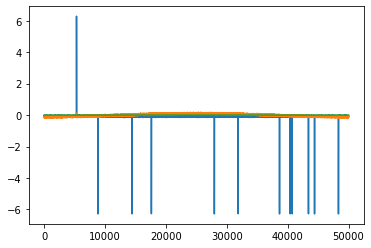

In [214]:
plt.plot(q_am.to_axis_angle)

## Filtering

$
\mathbf{q} = (1 - \alpha) \mathbf{q}_\omega + \alpha\mathbf{q}_{am}, \quad \alpha \in (0, 1)
$


In [225]:
α = 0.4

q_filter = (1 - α) * q_gyro + α * q_am

(-0.1, 0.4)

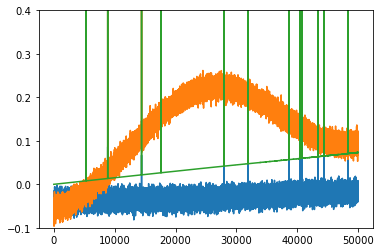

In [229]:
plt.plot(q_filter.to_axis_angle)
plt.ylim(-0.1, 0.4)

In [237]:
α = 0.7

q_filter = (1 - α) * q_gyro + α * q_am

(-0.1, 0.4)

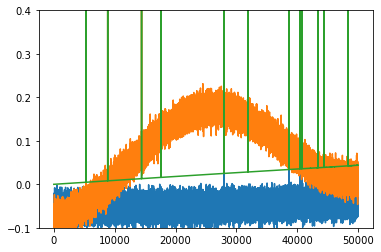

In [238]:
plt.plot(q_filter.to_axis_angle)
plt.ylim(-0.1, 0.4)